In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
# Keep original 28x28 images
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 60000 images
Test set: 10000 images


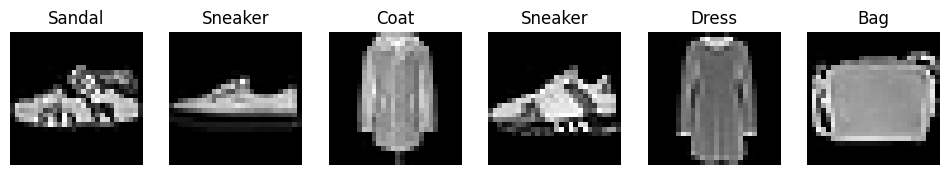

In [9]:
classes = train_dataset.classes

def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_samples()

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)  # Flatten 28x28 → 784
        # two hidden layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



Using device: cpu


c:\Users\101031719\Documents\Image-Classification-on-the-Fashion-MNIST-Dataset-against-different-NN-models\.venv\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: cudaGetDeviceCount() returned cudaErrorNotSupported, likely using older driver or on CPU machine (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:88.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/5] - Loss: 0.5305
Epoch [2/5] - Loss: 0.3700
Epoch [3/5] - Loss: 0.3309
Epoch [4/5] - Loss: 0.3038
Epoch [5/5] - Loss: 0.2902


In [13]:
model.eval()
correct, total = 0, 0
all_preds = []
all_labels = []

misclassified_images = []
misclassified_preds = []
misclassified_labels = []


In [14]:

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        mask = predicted != labels

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

        total += labels.size(0)
        masks = predicted != labels

        correct += (~masks).sum().item()

        for img, pred, label, is_wrong in zip(images, predicted, labels, mask):
            if is_wrong:
                misclassified_images.append(img.cpu())
                misclassified_preds.append(pred.cpu().item())
                misclassified_labels.append(label.cpu().item())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 87.34%


<Figure size 1700x1200 with 0 Axes>

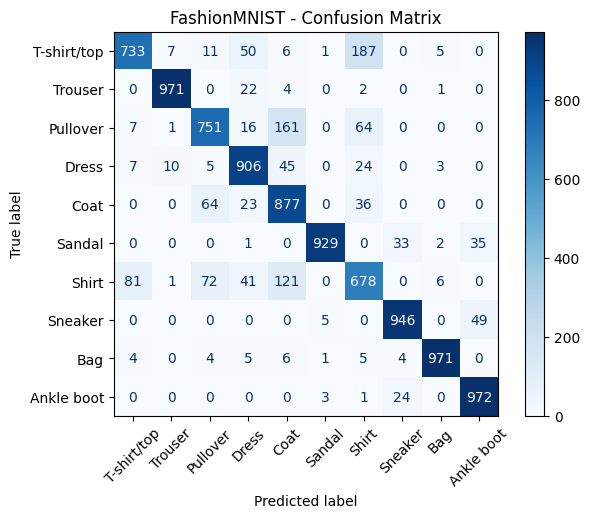

In [20]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_dataset.classes)

plt.figure(figsize=(17, 12))
disp.plot(cmap="Blues", values_format="d")
plt.title("FashionMNIST - Confusion Matrix")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

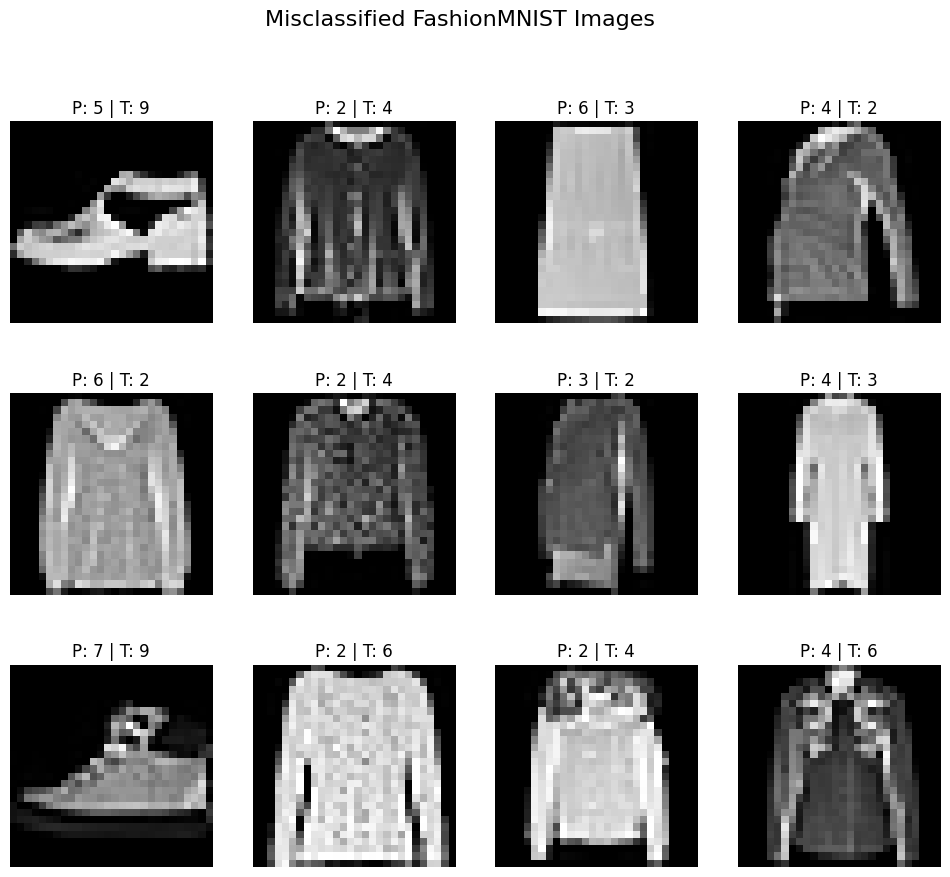

In [16]:
num_to_show = 12
plt.figure(figsize=(12, 10))

for i in range(num_to_show):
    plt.subplot(3, 4, i+1)
    plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
    plt.title(f"P: {misclassified_preds[i]} | T: {misclassified_labels[i]}")
    plt.axis("off")

plt.suptitle("Misclassified FashionMNIST Images", fontsize=16)
plt.show()